# This is the Spaceship Titanic
## Kaggle Competition

### 1. Assemble the data
### 2. Visualize, shape, and engineer it
### 3. Train a model
### 4. Predict and submit

### 1. Assemble the data

Data description:

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')

### 2. Visualize, shape, and engineer the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [5]:
df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [6]:
df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

### Data findings:

- 8693 total passengers in this set. Null values are located in every column except 'PassengerId' and the target 'Transported.'
- Passenger groups should be compared and if NaNs are found in groups then set those NaNs to the same as the others in the group, except for expenditure. Expenditure NaN should be set to 0 because we are assuming these groups might have children and just the parents paid. 'Age' will be set to mean.
- Else, 'CryoSleep' and 'VIP' null values will be set to False since that's the most common.
- NOTE: nan values appear to be floats. Will convert to 'nan' string for comparison.
- 'PassengerID' can be engineered since it tells us if they were in a group. Passengers in a group were probably more likely to be transported together.
- 'HomePlanet' probably useless but it's possible they're grouped together.
- 'CryoSleep' is important since they might be in the cabin, or if they're out and about.
- 'Cabin' will need to be feature engineered since it contains several features and is useless in it's current state. It contains valuable data though since once it's split into three values (deck, number, side) we'll be able to pinpoint where the space anomaly hit the ship.
- 'Destination' is probably useless but it might be possible they're grouped together on the ship.
- 'Age', 'VIP', and all expenditures will be pd.dummied or normalized.
- 'Name' is useless since it's unique for every passenger and will be removed.

Second run through:
- We're going to add total expenses
- We're going to set CryoSleep on anyone age >= 13 who had no expenses who had a nan for CryoSleep

In [7]:
# Preprocess data
def preprocess(passed_df):

    def remove_useless_columns(passed_df):
        # We'll remove the useless features
        useless_columns = ['Name']
        passed_df = passed_df.drop(useless_columns, axis=1)

        return passed_df

    def pass_id_group(passed_df):
        # We'll remove the passenger number and just leave the group number
        for row in passed_df.index:
            raw_id = str(passed_df.at[row, 'PassengerId'])
            fixed_id = raw_id.split('_')
            fixed_id = fixed_id.pop(0)
            passed_df.at[row, 'PassengerId'] = int(fixed_id)
        passed_df.rename(columns={'PassengerId': 'PassengerGroup'}, inplace=True)

        return passed_df

    def total_expenses(passed_df):
        expenditure_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        # Expenditure columns will be zeroed since we assume families spent together and can't guess otherwise.
        print('Filling ', expenditure_columns, 'nan values with 0.')
        passed_df[expenditure_columns] = passed_df[expenditure_columns].fillna(value=0)
        for row in passed_df.index:
            total_spent = 0
            for column in expenditure_columns:
                total_spent += passed_df.at[row, column]
            passed_df.at[row, 'TotalSpent'] = total_spent

        return passed_df

    def fix_null_values(passed_df):
        # Clean any columns right off the bat that we know we can fill.
        passed_df['Age'].fillna(value=passed_df['Age'].mean(), inplace=True)
        # Next we'll take a look at the rest of the columns that have nulls, except age which will be .mean(). These columns will have their 'PassengerGroup' searched for non-null values and if they have a group with the same values available then they will be filled with that. Otherwise they'll be given 'missing' or 0 depending on which column.
        columns_to_compare = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
        for column in columns_to_compare:
            # We fill the missing float nan values that pandas gives us with a simple 'nan' string that makes comparison easy.
            passed_df[column].fillna(value='nan', inplace=True)
            # Including a counter for printing.
            nan_values = 0
            for row in passed_df.index:
                value = passed_df.at[row, column]
                if value == 'nan':
                    nan_values += 1
                    # Here we find the passenger group id and use it to create a small temporary Dataframe to search.
                    group_id = passed_df.at[row, 'PassengerGroup']
                    df_pass_groups = passed_df.loc[passed_df['PassengerGroup'] == group_id]
                    # We check here if there are others in their group. If not then we just fill with 'missing' or 0.
                    if len(df_pass_groups) > 1:
                        for pass_rows in df_pass_groups.index:
                            pass_value = df_pass_groups.at[pass_rows, column]
                            # If others in the group have the proper value then it's captured and filled.
                            if pass_value != 'nan':
                                not_null_value = df_pass_groups.at[pass_rows, column]
                        passed_df.at[row, column] = not_null_value
                    # Here we fill 0 or 'missing' if we don't have a group to compare to.
                    else:
                        if column == 'VIP' or column == 'CryoSleep':
                            # Let's set 'CryoSleep' to true on rows with 'Age' >= 13, but 'TotalSpent' at 0.
                            age = int(passed_df.at[row, 'Age'])
                            total_spent = float(passed_df.at[row, 'TotalSpent'])
                            if age >= 13 and total_spent == 0:
                                passed_df.at[row, column] = 1
                            else:
                                passed_df.at[row, column] = 0
                        else:
                            passed_df.at[row, column] = 'missing'
            print('Fixed', nan_values, 'values in', column, '.')
        # Dropping total spent column since this number is contained in all the expenditure columns and it caused the model to lean too heavily on it.
        passed_df = passed_df.drop('TotalSpent', axis=1)

        return passed_df

    def boolean_convert(passed_df):
        # Here we'll just convert these two boolean columns to int. This isn't strictly necessary but it looks better when I view the dataframe.
        passed_df['CryoSleep'] = passed_df['CryoSleep'].astype(int)
        passed_df['VIP'] = passed_df['VIP'].astype(int)

        return passed_df

    def convert_cabins(passed_df):
        # In this function we'll feature engineer the cabins and give them deck, cabin number, and side (port or starboard).
        # There are 8 decks, represented as A, B, C, D, E, F, G, and T. We will rewrite these with their number.
        # We will leave the cabin number as is.
        # We will write port and starboard as 0 for port, 1 for starboard.
        # Any 'missing' values will simply have 0.
        deck_dict = {'A': 1,
                     'B': 2,
                     'C': 3,
                     'D': 4,
                     'E': 5,
                     'F': 6,
                     'G': 7,
                     'T': 8}
        side_dict = {'P': 0,
                     'S': 1}
        not_missing = 0
        missing = 0
        for row in passed_df.index:
            value = str(passed_df.at[row, 'Cabin'])
            if value != 'missing':
                not_missing += 1
                value_list = value.split('/')
                passed_df.at[row, 'Deck'] = int(deck_dict[value_list[0]])
                passed_df.at[row, 'CabinNumber'] = int(value_list[1])
                passed_df.at[row, 'Side'] = int(side_dict[value_list[2]])
            elif value == 'missing':
                missing += 1
                passed_df.at[row, 'Deck'] = int(0)
                passed_df.at[row, 'CabinNumber'] = int(0)
                passed_df.at[row, 'Side'] = int(0)
        # Remove the old 'Cabin' column
        passed_df = passed_df.drop('Cabin', axis=1)
        print(f'{not_missing} cabin values determined from Cabin feature, {missing} cabin values missing.')

        return passed_df

    # Call all the functions
    df = remove_useless_columns(passed_df)
    df = pass_id_group(df)
    df = total_expenses(df)
    df = fix_null_values(df)
    df = boolean_convert(df)
    df = convert_cabins(df)

    return df

In [8]:
df = preprocess(df)
df.info()
# 9246 passenger should have true cryosleep

Filling  ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] nan values with 0.
Fixed 201 values in HomePlanet .
Fixed 217 values in CryoSleep .
Fixed 199 values in Cabin .
Fixed 182 values in Destination .
Fixed 203 values in VIP .
8594 cabin values determined from Cabin feature, 99 cabin values missing.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerGroup  8693 non-null   object 
 1   HomePlanet      8693 non-null   object 
 2   CryoSleep       8693 non-null   int32  
 3   Destination     8693 non-null   object 
 4   Age             8693 non-null   float64
 5   VIP             8693 non-null   int32  
 6   RoomService     8693 non-null   float64
 7   FoodCourt       8693 non-null   float64
 8   ShoppingMall    8693 non-null   float64
 9   Spa             8693 non-null   float64
 10  VRDeck          8693 non-null  

In [9]:
# Import the old df for comparison purposes.
df_old = pd.read_csv('train.csv')

<AxesSubplot: >

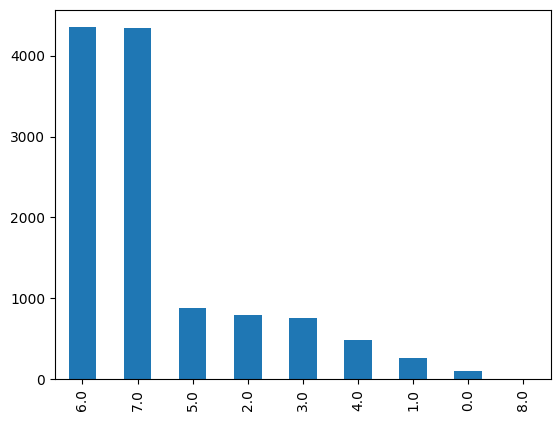

In [10]:
df.Side.value_counts().plot(kind='bar')
df.Deck.value_counts().plot(kind='bar')

<AxesSubplot: ylabel='Frequency'>

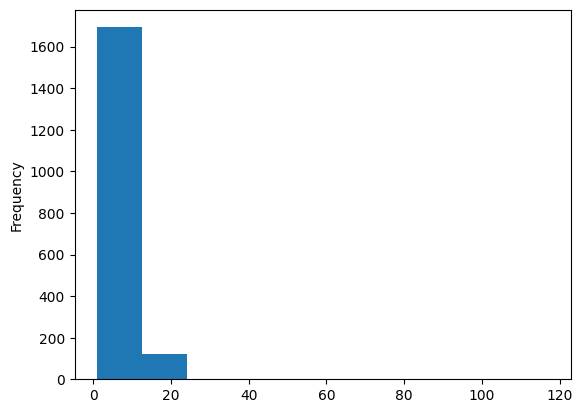

In [11]:
df.CabinNumber.value_counts().plot(kind='hist')

### 3. Train a model
Let's start predicting!

In [12]:
# Function to transform the data to a readable version
def transform_data(passed_X):
    # We'll fit our categorical data with get_dummies()
    categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side']
    passed_X = pd.get_dummies(passed_X, prefix=categorical_features, columns=categorical_features)

    return passed_X

In [56]:
# We'll try the simple, stock RandomForestClassifier first.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop(['Transported'], axis=1)
y = df['Transported']

X = transform_data(X)
# Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf = RandomForestClassifier(random_state=42, n_estimators=3000, min_samples_split=5,
                             min_samples_leaf=5, max_features='sqrt', max_depth=20,
                             criterion='entropy', n_jobs=-1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8033352501437608

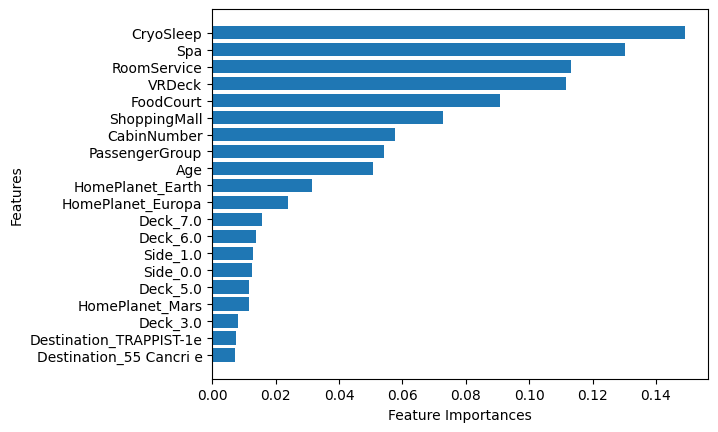

In [14]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True)
          )

    fix, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importances")
    ax.invert_yaxis()


plot_features(X.columns, clf.feature_importances_)

As suspected their location plays a big role since only part of the ship got hit (see 'CabinNumber'). Group plays a role since they were likely together. Expenditures play a role since it might have determined if they were in the cabin or not. CryoSleep for the same reason. Surprisingly decks didn't play a big role.

In [15]:
# Let's tune the model.
# from sklearn.model_selection import GridSearchCV
#
# tuning_params = {'n_estimators': [100, 1000, 5000, 10000],
#                  'max_depth': [None, 3, 5],
#                  'min_samples_split':(2, 5, 10, 20),
#                  'min_samples_leaf': (2, 5, 10, 20),
#                  'max_features': [0.5, 1, "sqrt"]}
#
# gs_clf = GridSearchCV(estimator=clf, param_grid=tuning_params, cv=3, verbose=0, n_jobs=-1)
# gs_clf.fit(X, y)

In [37]:
from sklearn.model_selection import RandomizedSearchCV
import time

start = time.time()

tuning_params = {
                 'max_depth': [None, 3, 5],
                 'min_samples_split':(2, 5, 10, 20),
                 'criterion': ['gini', 'entropy', 'log_loss'],
                 'min_samples_leaf': (2, 5, 10, 20),
                 'max_features': [0.5, 1, "sqrt"]}

gs_clf = RandomizedSearchCV(estimator=clf, n_iter=100, param_distributions=tuning_params, cv=2, verbose=0, n_jobs=10, random_state=42)
gs_clf.fit(X_train, y_train)

end = time.time()
print(end - start, 'seconds elapsed')

print(gs_clf.score(X_test, y_test))
print(gs_clf.best_params_)

45.61601758003235 seconds elapsed
0.7998849913743531
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}


{'n_estimators': 10000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None}
0.803

In [17]:
def evaluation_block_classifier(model, X, y, X_test, y_test):

    """
    :param model: name of classifier
    :param X: name of X data (non-target)
    :param y: name of y data (target)
    :param X_test: name of X test data (non-target)
    :param y_test: name of y test data (target)
    :param roc_graph: boolean to determine if ROC graph is plotted and displayed
    """

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
    from sklearn.model_selection import cross_val_score
    from numpy import mean as npmean
    import matplotlib.pyplot as plt

    # Get y_preds
    preds = model.predict(X_test)

    # Evaluation block for singular metrics (non-cross validated)
    print("Singular classifier metrics on test set:")
    print(f'Accuracy: {accuracy_score(y_test, preds)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, preds)}')
    print(f'Recall: {recall_score(y_test, preds)}')
    print(f'F1: {f1_score(y_test, preds)}')
    print('')

    # Evaluation block for cross val
    print("Cross validation classifier metrics on test set:")
    print(f'Accuracy: {npmean(cross_val_score(model, X, y, cv=5, scoring="accuracy"))*100:.2f}%')
    print(f'Precision: {npmean(cross_val_score(model, X, y, cv=5, scoring="precision"))}')
    print(f'Recall: {npmean(cross_val_score(model, X, y, cv=5, scoring="recall"))}')
    print(f'F1: {npmean(cross_val_score(model, X, y, cv=5, scoring="f1"))}')
    print('')

    y_probs = model.predict_proba(X_test)
    y_probs_positive = y_probs[:, 1]


    # Define and gather data to plot ROC curve

    fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)

    def plot_roc_curve(fpr, tpr):

        # Plots our ROC curve given the FPR and TPR
        plt.plot(fpr, tpr, color='orange', label="ROC")

        # Plot line with no predictive power (baseline)
        plt.plot([0,1], [0,1], color='darkblue', linestyle='--', label='Guessing')

        # Customize
        plt.xlabel('False positive rate (FPR)')
        plt.ylabel('True positive rate (TPR)')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    plot_roc_curve(fpr, tpr)
    print(f'ROC AUC score: {roc_auc_score(y_test, y_probs_positive)}')

Singular classifier metrics on test set:
Accuracy: 79.93%
Precision: 0.7942157953281423
Recall: 0.8132118451025057
F1: 0.8036015756893641

Cross validation classifier metrics on test set:
Accuracy: 77.87%
Precision: 0.8534234180881498
Recall: 0.696915329419439
F1: 0.7529139164562831



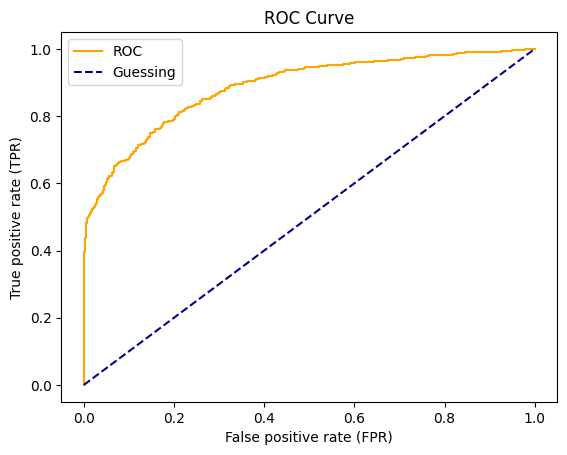

ROC AUC score: 0.8867847155529804


In [18]:
evaluation_block_classifier(clf, X, y, X_test, y_test)

I'm getting a 80.3% score with RF. Let's try a Linear SVC.

In [19]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['Transported'], axis=1)
y = df['Transported']

X = transform_data(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf_svc = LinearSVC(random_state=42, max_iter=10000)
clf_svc.fit(X_train, y_train)
clf_svc.score(X_test, y_test)

H:\kaggle\spaceship-titanic\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7814836112708453

Now let's try KNeighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['Transported'], axis=1)
y = df['Transported']

X = transform_data(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

clf_kne = KNeighborsClassifier()
clf_kne.fit(X_train, y_train)
clf_kne.score(X_test, y_test)

0.7492811960897068

Looks like RF is our winner so far.

### 4. Predict and Submit

In [21]:
# Let's predict and submit our score for evaluation and see where we're at.
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [57]:
# Retrain model on full training set.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop(['Transported'], axis=1)
y = df['Transported']

X = transform_data(X)

clf = RandomForestClassifier(random_state=42, n_estimators=3000, min_samples_split=5,
                             min_samples_leaf=5, max_features='sqrt', max_depth=20,
                             criterion='entropy', n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=3000, n_jobs=-1,
                       random_state=42)

In [58]:
def predict_and_package(passed_df):
    # Grab passenger ids for final submission
    test_df_passids = pd.DataFrame(passed_df['PassengerId'])
    # Create the predictions
    test_df = preprocess(passed_df)
    test_df = transform_data(test_df)
    test_preds = clf.predict(test_df)
    # Transpose and concatenate
    test_preds_df = pd.DataFrame(test_preds, columns=['Transported'])
    test_preds_df['Transported'] = test_preds_df['Transported'].astype(bool)
    print(test_preds_df.head())
    submission = pd.concat([test_df_passids, test_preds_df], axis=1, join='inner')

    return submission

In [59]:
submission = predict_and_package(test_df)
print(submission.head())
print(submission.info())

Filling  ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] nan values with 0.
Fixed 87 values in HomePlanet .
Fixed 93 values in CryoSleep .
Fixed 100 values in Cabin .
Fixed 92 values in Destination .
Fixed 93 values in VIP .
4216 cabin values determined from Cabin feature, 61 cabin values missing.
   Transported
0         True
1        False
2         True
3         True
4         True
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB
None


In [60]:
submission.to_csv('submission.csv', index=False)

# Results

## First results: 0.80079 Rank 923

## Second Results: 0.80219 Rank 817
### Second iteration changes:
- Total expenses added, used, and removed when it was causing the model to favor that column too much.
- Children are 12 and under, since expenses only show up at 13 years old.
- If someone spent nothing, and they're an adult (over 13 years old), and they have a nan for cryosleep then we can set them to true because they were likely asleep.

## Third Results: 0.80289 Rank 761
### Third iteration changes:
- Added criterion: 'entropy' to clf estimator
- Trained estimator on entire training set prior to submission

## Fourth Results: 0.80360 Rank 683
### Fourth iteration changes:
- Further tuned clf parameters

### Notes:
- Need to extrapolate missing expenditures
- Can find people age 13 >= that have nan expenditures and extrapolate the median expenditure in that column
- Check to see if expenditures go by age? Older and they spend more?
- Could also use age and deck to help extrapolate missing expenditures.. presumably lower deck numbers (higher on the ship) will have more money
- Does destination or port of entry have anything to do with how much they spent? Can that be used?